# Lesson 3: Expand Data Agent Capabilities

You can use [Cortex agents](https://docs.snowflake.com/en/user-guide/snowflake-cortex/cortex-agents) to retrieve data across unstructured and structured systems. In this example, the agent will answer questions from structured CRM data and unstructured meeting notes. This addition will empower your multi-agent system to be able to answer deeper questions requiring reasoning across many different data sources.

## 3.1 Load the environment

The environment variables include the OpenAI API and Tavily API keys, and the Snowflake credentials required to access the Snowflake account created for this course. The environment variables also define the name of the database where the provided data is stored.

In [1]:
from dotenv import load_dotenv
_ = load_dotenv(override=True)

**Notes**: 

- These variables are already defined in this environment. If you'd like to run the notebook locally, you can define them in a `.env` file. For an env template, you can check the file `env.template` in this lesson's folder.
- To learn more about how the data was set up for this course, you can check this [guide](https://quickstarts.snowflake.com/guide/getting_started_with_cortex_agents/index.html#0).

<div style="background-color:#fff6ff; padding:13px; border-width:3px; border-color:#efe6ef; border-style:solid; border-radius:6px">
<p> 💻 &nbsp; <b>To access <code>requirements.txt</code>, <code>env.template</code>, <code>prompts.py</code>, and <code>helper.py</code> files:</b> 1) click on the <em>"File"</em> option on the top menu of the notebook 2) click on <em>"Open"</em>.

<p> ⬇ &nbsp; <b>Download Notebooks:</b> 1) click on the <em>"File"</em> option on the top menu of the notebook and then 2) click on <em>"Download as"</em> and select <em>"Notebook (.ipynb)"</em>.</p>

</div>

## 3.2 Explore the data

The structured data (accessed via [Cortex Analyst](https://docs.snowflake.com/en/user-guide/snowflake-cortex/cortex-analyst)) is Customer Relationship Management (CRM) data, containing recent deals with values, company names, deal status, product lines, and more.

The unstructured data (accessed via [Cortex Search](https://docs.snowflake.com/user-guide/snowflake-cortex/cortex-search/cortex-search-overview)) contains notes from meetings with these prospective customers.

By using both the structured and unstructured data, you can ask analytical questions about recent deal values, uncover themes from the notes, or even combine the information to go even deeper.

When combined with public data, you can uncover deep, actionable insights from your data!

### Structured data: CRM/deal data

In [2]:
from helper import snowpark_session

/Users/mykielee/GitHub/deeplearning.ai-course/Building and Evaluating Data Agents/adapters/local_cortex_agent.py:74: UserWarning: Chroma unavailable, using simple text search fallback: Server disconnected without sending a response.
  warnings.warn(f"Chroma unavailable, using simple text search fallback: {e}")


In [3]:
import pandas as pd

snowpark_session.sql("USE WAREHOUSE SALES_INTELLIGENCE_WH").collect()
pd.DataFrame(snowpark_session.sql("select * from sales_intelligence.data.sales_metrics limit 5").collect())

ℹ️  Skipping Snowflake-specific command: USE WAREHOUSE SALES_INTELLIGENCE_WH
ℹ️  Translated schema reference: select * from data.sales_metrics limit 5


,DEAL_ID,COMPANY_NAME,DEAL_VALUE,SALES_REP,CLOSE_DATE,DEAL_STATUS,PRODUCT_LINE,CREATED_AT,UPDATED_AT
0,1,Acme Corporation,150000.00,John Smith,2024-03-15,Closed Won,Enterprise Software,2025-09-28 22:00:53.066800,2025-09-28 22:00:53.066800
1,2,Global Dynamics,250000.00,Mike Johnson,2024-02-28,Closed Won,AI Platform,2025-09-28 22:00:53.066800,2025-09-28 22:00:53.066800
2,3,DataMax Systems,320000.00,Robert Taylor,2024-01-20,Closed Won,Enterprise Software,2025-09-28 22:00:53.066800,2025-09-28 22:00:53.066800
3,4,AI Innovations,210000.00,James Wilson,2024-02-14,Closed Won,AI Platform,2025-09-28 22:00:53.066800,2025-09-28 22:00:53.066800
4,5,DataVision Inc,195000.00,Amanda Thompson,2024-01-15,Closed Won,Enterprise Software,2025-09-28 22:00:53.066800,2025-09-28 22:00:53.066800


### Unstructured data: meeting notes

In [4]:
import textwrap

rows = snowpark_session.sql("""
    select transcript_text
    from sales_intelligence.data.sales_conversations
    limit 1
""").collect()

if not rows:
    print("No transcripts found.")
else:
    try:
        transcript = rows[0]['TRANSCRIPT_TEXT']  # Snowflake usually uppercases column names
    except Exception:
        transcript = rows[0][0]

    cleaned = " ".join(transcript.split())  # collapse excessive whitespace/newlines
    wrapped = textwrap.fill(cleaned, width=100)

    print("=== Meeting Notes ===\n")
    print(wrapped)
    print("\n=== End ===")

ℹ️  Translated schema reference: select transcript_text
    from data.sales_conversations
    limit 1
=== Meeting Notes ===

Good morning John, thank you for taking the time to meet with us today. I understand you're looking
for an enterprise solution that can help streamline your operations. John: Yes, that's correct.
We've been evaluating several vendors and we're particularly interested in your AI platform
capabilities. Our main concerns are around security and compliance - we operate in a highly
regulated industry. Sarah: Absolutely, security is paramount in our solution. We have SOC 2 Type II
certification and we're compliant with GDPR, HIPAA, and other major regulatory frameworks. Can you
tell me more about your current infrastructure? John: We're primarily cloud-based, running on AWS.
We need something that can integrate seamlessly with our existing CRM system - we use Salesforce
extensively. The solution needs to handle about 5,000 users initially, but we're planning to scale
t

## 3.3 Initialize Cortex Agent 

This agent will retrieve sales-related data from Snowflake using both Text2SQL (done by Cortex Analyst) and Semantic Search (done by Cortex Search).

In [5]:
from snowflake.snowpark import Session
from snowflake.core import Root
from pydantic import BaseModel, PrivateAttr
from snowflake.core.cortex.lite_agent_service import AgentRunRequest
from typing import Any, Type
from langchain.schema import HumanMessage
from langgraph.graph import END
from langgraph.types import Command
from typing import Literal, Dict
import json

from helper import State

- The Cortex Analyst uses a semantic model to perform text-to-SQL conversion. You can learn more about semantic models [here](https://docs.snowflake.com/en/user-guide/snowflake-cortex/cortex-analyst/semantic-model-spec). 
- To be able to perform semantic search across your unstructured data stored in Snowflake, you can create a [Cortex Search service](https://docs.snowflake.com/en/user-guide/snowflake-cortex/cortex-search/cortex-search-overview#create-the-service).

To learn more about how the semantic model and the search service were created, you can check this [guide](https://quickstarts.snowflake.com/guide/getting_started_with_cortex_agents/index.html#0).

In [6]:
SEMANTIC_MODEL_FILE = "@sales_intelligence.data.models/sales_metrics_model.yaml"

CORTEX_SEARCH_SERVICE = "sales_intelligence.data.sales_conversation_search"

In [7]:
# ---- Agent Setup ----
class CortexAgentArgs(BaseModel):
    query: str

In [8]:
class CortexAgentTool:
    name: str = "CortexAgent"
    description: str = "answers questions using sales conversations and metrics"
    args_schema: Type[CortexAgentArgs] = CortexAgentArgs

    _session: Session = PrivateAttr()
    _root: Root = PrivateAttr()
    _agent_service: Any = PrivateAttr()

    def __init__(self, session: Session):
        self._session = session
        self._root = Root(session)
        self._agent_service = self._root.cortex_agent_service

    def _build_request(self, query: str) -> AgentRunRequest:
        return AgentRunRequest.from_dict({
            "model": "claude-3-5-sonnet",
            "tools": [
                {"tool_spec": {"type": "cortex_analyst_text_to_sql", "name": "analyst1"}},
                {"tool_spec": {"type": "cortex_search", "name": "search1"}},
            ],
            "tool_resources": {
                "analyst1": {"semantic_model_file": SEMANTIC_MODEL_FILE},
                "search1": {
                    "name": CORTEX_SEARCH_SERVICE,
                    "max_results": 10,
                    "id_column": "conversation_id"
                }
            },
            "messages": [
                {"role": "user", "content": [{"type": "text", "text": query}]}
            ]
        })

    def _consume_stream(self, stream):
        text, sql, citations = "", "", []
        for evt in stream.events():
            try:
                delta = (evt.data.get("delta") if isinstance(evt.data, dict)
                         else json.loads(evt.data).get("delta")
                         or json.loads(evt.data).get("data", {}).get("delta"))
            except Exception:
                continue

            if not isinstance(delta, dict):
                continue

            for item in delta.get("content", []):
                if item.get("type") == "text":
                    text += item.get("text", "")
                elif item.get("type") == "tool_results":
                    for result in item["tool_results"].get("content", []):
                        if result.get("type") != "json":
                            continue
                        j = result["json"]
                        text += j.get("text", "")
                        sql = j.get("sql", sql)
                        citations.extend({
                            "source_id": s.get("source_id"),
                            "doc_id": s.get("doc_id")
                        } for s in j.get("searchResults", []))
        return text, sql, str(citations)

    def run(self, query: str, **kwargs):
        """
        This agent will retrieve sales-related data from Snowflake using both Text2SQL and Semantic Search.
        """
        req = self._build_request(query)
        stream = self._agent_service.run(req)
        text, sql, citations = self._consume_stream(stream)

        results_str = ""
        if sql:
            try:
                # Ensure warehouse is set explicitly before running the SQL
                self._session.sql("USE WAREHOUSE SALES_INTELLIGENCE_WH").collect()

                df = self._session.sql(sql.rstrip(";")).to_pandas()
                results_str = df.to_string(index=False)
            except Exception as e:
                results_str = f"SQL execution error: {e}"

        return text, citations, sql, results_str

In [10]:
# Override with compatible CortexAgentTool
from helper import CortexAgentTool

In [11]:
cortex_agent_tool = CortexAgentTool(session=snowpark_session)

/Users/mykielee/GitHub/deeplearning.ai-course/Building and Evaluating Data Agents/adapters/local_cortex_agent.py:74: UserWarning: Chroma unavailable, using simple text search fallback: Server disconnected without sending a response.
  warnings.warn(f"Chroma unavailable, using simple text search fallback: {e}")


In [12]:
from langgraph.prebuilt import create_react_agent
from helper import agent_system_prompt
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o")

cortex_agent = create_react_agent(
    llm,
    tools=[cortex_agent_tool.run],
    prompt=agent_system_prompt(f"""
        You are the Researcher. You can answer questions 
        using customer deal data along with meeting notes.
        Do not take any further action.
    """))

<p style="background-color:#fff6e4; padding:15px; border-width:3px; border-color:#f5ecda; border-style:solid; border-radius:6px"> ⏳ </b> The following two queries might take a few minutes to output the results.</p>

<div style="background-color:#f7fff8; padding:15px; border-width:3px; border-color:#e0f0e0; border-style:solid; border-radius:6px"> 
    <p>🚨 &nbsp; <b>Different Run Results:</b> If the agent does not return the top 3 client deals and mentions it can't access the structured data, it could be because it did not choose the Cortex Analyst tool (which gives it access to the structured data containing client deals) and chose the Cortex Search tool instead (which gives it access to the meeting notes). You do not need to re-run the queries.
</div>

In [13]:
agent_response = cortex_agent.invoke(
    {"messages":"what are our top 3 customer deals?"})

print(agent_response['messages'][-1].content)

FINAL ANSWER: The top three customer deals are:

1. PipelineCorp with a deal value of $300,000.
2. Enterprise Solutions LLC with a deal value of $280,000.
3. Global Dynamics with a deal value of $250,000.


In [14]:
agent_response = cortex_agent.invoke(
    {"messages":"what is the next step in the sales process for healthtech"})

print(agent_response['messages'][-1].content)

I'm unable to find specific information regarding the next step in the sales process for the "healthtech" industry from the available data. The structured data contains details on deal status for various companies and products, but it doesn't specify the industry or the precise next step within the sales process. Additionally, there are no relevant meeting notes related to this query.

To provide a specific answer, it would require additional data containing information about the sales process steps specifically for the healthtech industry. If that data is available, please provide it or adjust your query.


Let's now wrap a LangGraph node around the react agent.

In [15]:
def cortex_agents_research_node(
    state: State,
) -> Command[Literal["executor"]]:
    query = state.get("agent_query", state.get("user_query", ""))
    # Call the tool with the string query
    agent_response = cortex_agent.invoke({"messages":query})
    # Compose a message content string with all results new HumanMessage with the result
    new_message = HumanMessage(content=agent_response['messages'][-1].content, name="cortex_researcher")
    # Append to the message history
    goto = "executor"
    return Command(
        update={"messages": [new_message]},
        goto=goto,
    )

## 3.4 Build the agent graph

In [16]:
from helper import State, planner_node, executor_node, web_research_node, chart_node, chart_summary_node, synthesizer_node

from langgraph.graph import START, StateGraph

workflow = StateGraph(State)
workflow.add_node("planner", planner_node)
workflow.add_node("executor", executor_node)
workflow.add_node("web_researcher", web_research_node)
workflow.add_node("cortex_researcher", cortex_agents_research_node)
workflow.add_node("chart_generator", chart_node)
workflow.add_node("chart_summarizer", chart_summary_node)
workflow.add_node("synthesizer", synthesizer_node)

workflow.add_edge(START, "planner")

graph = workflow.compile()

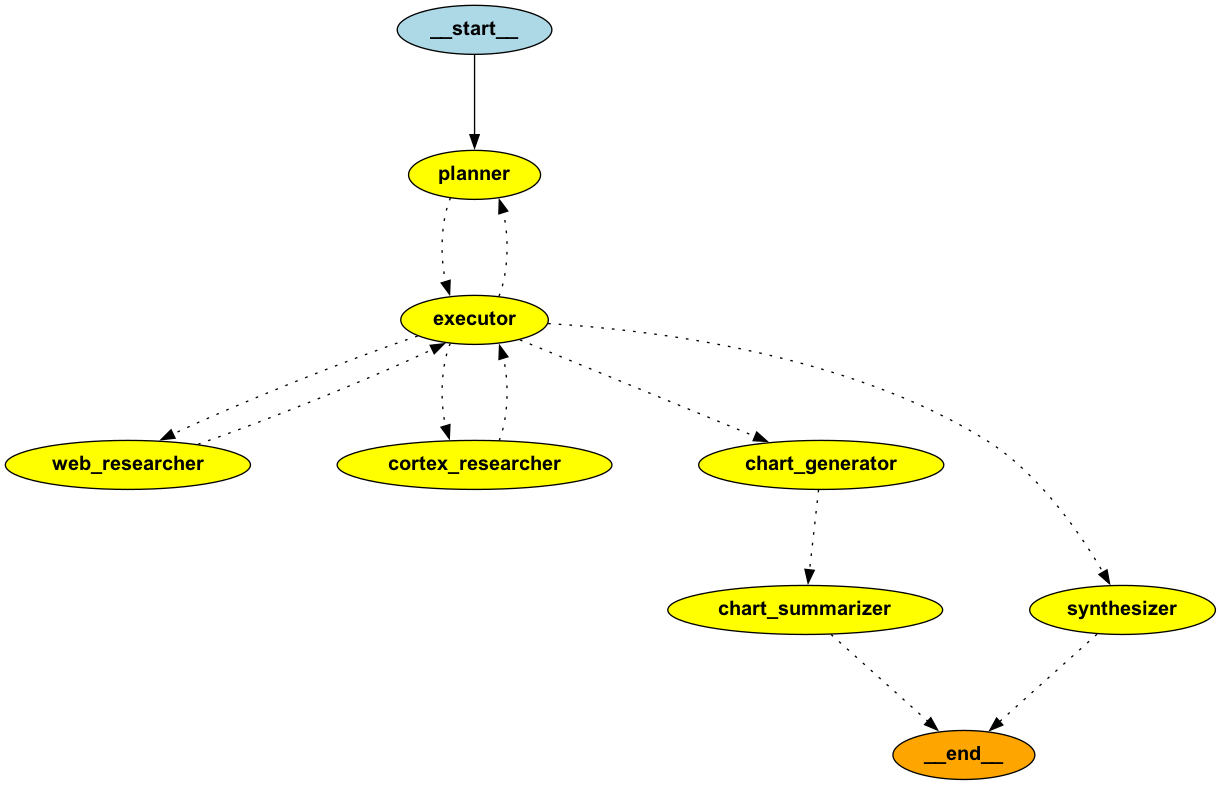

In [17]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_png()))

## 3.5 Use the agent

<div style="background-color:#f7fff8; padding:15px; border-width:3px; border-color:#e0f0e0; border-style:solid; border-radius:6px"> 
<p>🚨 &nbsp; <b>Different Run Results:</b> The output generated by AI chat models can vary with each execution due to their dynamic, probabilistic nature. Your results may differ from those shown in the video.

**It's expected for the agent to not answer perfectly**:

- If the first query does not chart any results, or plots a chart showing companies A, B and C, or mentions that it doesn't have access to the required data, that's okay. It might be because the Cortex agent decided to choose the Cortex Search tool (access to meeting notes only) instead of the Cortex Analyst tool (access to client deals data). You do not need to re-run the queries.
- The same applies to the second and third queries. If the agent does not return a perfect answer, that's okay. You do not need to re-run it.
</div>

<p style="background-color:#fff6e4; padding:15px; border-width:3px; border-color:#f5ecda; border-style:solid; border-radius:6px"> ⏳ </b> The following three queries might take <b>2-5 minutes</b> to output the results.</p>

Query: What are our top 3 customer deals? Chart the deal value for each.


Python REPL can execute arbitrary code. Use with caution.


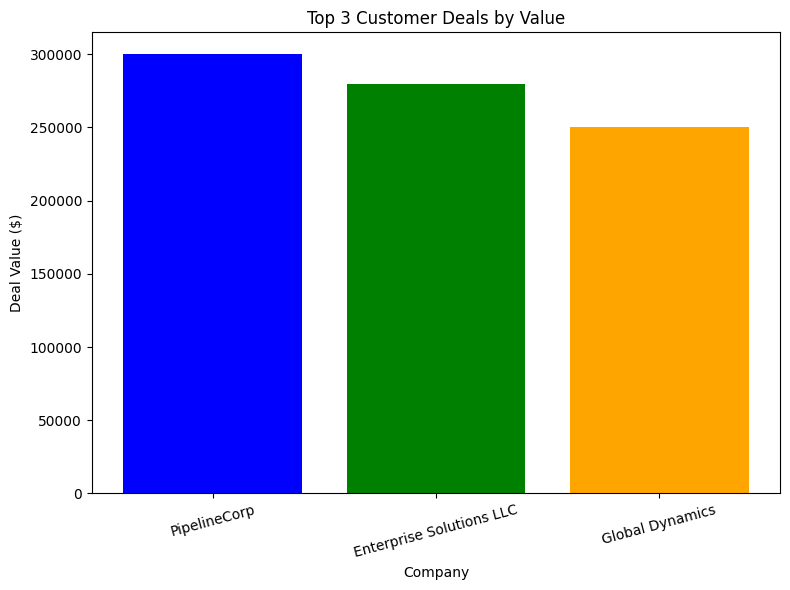

Chart summarizer answer: FINAL ANSWER: The top three customer deals by value are led by PipelineCorp with a deal worth $300,000, followed by Enterprise Solutions LLC at $280,000, and Global Dynamics at $250,000.
--------------------------------


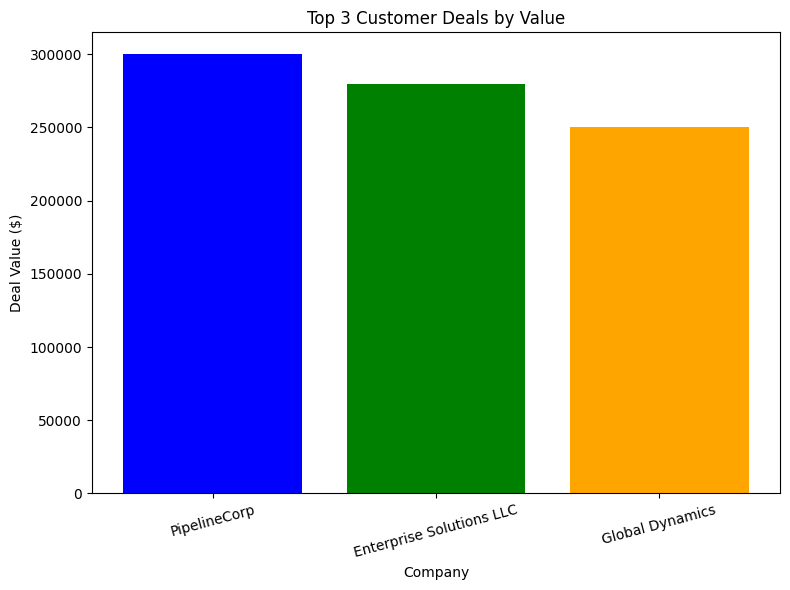

In [18]:
from langchain.schema import HumanMessage

query = "What are our top 3 customer deals? Chart the deal value for each."
print(f"Query: {query}")
state = {
            "messages": [HumanMessage(content=query)],
            "user_query": query,
            "enabled_agents": ["cortex_researcher", "web_researcher", "chart_generator", "chart_summarizer", "synthesizer"],
        }
graph.invoke(state)

print("--------------------------------")

In [19]:
query = "Identify our pending deals, research if they may be experiencing regulatory changes, and using the meeting notes for each customer, provide a new value proposition for each given the regulatory changes."
print(f"Query: {query}")

state = {
            "messages": [HumanMessage(content=query)],
            "user_query": query,
            "enabled_agents": ["cortex_researcher", "web_researcher", "chart_generator", "chart_summarizer", "synthesizer"],
        }
graph.invoke(state)

print("--------------------------------")

Query: Identify our pending deals, research if they may be experiencing regulatory changes, and using the meeting notes for each customer, provide a new value proposition for each given the regulatory changes.
Synthesizer answer: - **TechStart Inc:**  
  With the upcoming DFARS regulation impacting cloud services for defense, TechStart Inc can position its solution by highlighting enhanced security measures tailored for compliance, ensuring uninterrupted service with the Department of Defense.

- **FutureTech Ltd:**  
  In light of the EU Data Act, FutureTech can offer competitive pricing and improved interoperability that aligns with new switching mandates, positioning their services as adaptable and future-proof within the European market.

- **CloudLogic Systems:**  
  Given GDPR updates, CloudLogic Systems can emphasize strong data protection and quicker breach response capabilities, showcasing real-time compliance monitoring as a key differentiator in data analytics solutions.

- 

In [20]:
query = "Is there a common theme across our meeting notes?"
print(f"Query: {query}")

state = {
            "messages": [HumanMessage(content=query)],
            "user_query": query,
            "enabled_agents": ["cortex_researcher", "web_researcher", "chart_generator", "chart_summarizer", "synthesizer"],
        }
graph.invoke(state)

print("--------------------------------")

Query: Is there a common theme across our meeting notes?
Synthesizer answer: The common theme across the latest sales meeting notes is a focus on the technical requirements and integration needs of potential clients. The discussions include CRM and Salesforce integration, cloud-native solutions, and security and compliance concerns, indicating a trend towards technology-driven solutions and integration capabilities. Additionally, proposal phases and discovery discussions highlight a structured approach to client engagement. Global Dynamics closed a deal for an AI Platform worth $250,000, aligning with the proposal discussions in the meeting notes.

Citations: [Latest sales meeting notes]
--------------------------------


To ensure high quality, you need to add observability!

In the next lesson, you'll add tracing and goal completion evaluation to understand your agent's performance.